In [27]:
import datetime
import pandas as pd
import random
import numpy as np
import seaborn as sns
import math
# Set display format to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [2]:

rng = np.random.default_rng(123)

start_year = 1950
end_year = 2050
portfolios = ["First", "Second", "Third", "Fourth", "Fifth"]
portfolios_list = []
dates_list = []


for portfolio in portfolios:
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            date = datetime.date(year, month, 1)
            dates_list.append(date)
            portfolios_list.append(portfolio)

random_returns = rng.uniform(low=0, high=(0.10 / 12), size=len(dates_list))


returns = pd.DataFrame(
    {"Portfolio": portfolios_list, "date": dates_list, "ret": random_returns}
)


returns['income'] = 0.0

In [3]:
returns

,Portfolio,date,ret,income
0,First,1950-01-01,0.006,0.000
1,First,1950-02-01,0.000,0.000
2,First,1950-03-01,0.002,0.000
3,First,1950-04-01,0.002,0.000
4,First,1950-05-01,0.001,0.000
...,...,...,...,...
6055,Fifth,2050-08-01,0.007,0.000
6056,Fifth,2050-09-01,0.004,0.000
6057,Fifth,2050-10-01,0.006,0.000
6058,Fifth,2050-11-01,0.001,0.000


In [42]:
# Some pseudo code

# Input variables (these require input from the user, MANDATORY)

submitted_income = 85000
income_growth = 0.035

household_size = 2

monthly_income = submitted_income/12
monthly_growth = 1+ (income_growth/12)

start_savings = 25
retirement_start = 65
death_year = 85

month_start_savings = start_savings*12
month_retirement_start = retirement_start*12
death_month = death_year*12

inher_util = 2360
risk_aversion = 3.84



# I think I just want these to be static
save_rate = 0.10
consumption_rate = 0.04
inflation = 0.02

inflation_rate = inflation/12


# STATIC
inher_luxury = 490000

In [5]:
total_monthly_incomes = []

for t in returns.index[month_start_savings:month_retirement_start]:
    current_month = t-month_start_savings
    income_for_month = monthly_income*(monthly_growth**current_month)
    total_monthly_incomes.append(income_for_month)


In [6]:
# Apply mapping to DataFrame's index to create a month column that resets for each portfolio
returns['month'] = returns.groupby('Portfolio').cumcount()

# Map the total_monthly_incomes to each row based on the month
income_series = pd.Series(total_monthly_incomes, index=range(month_start_savings, month_retirement_start))
returns['income'] = returns['month'].map(income_series)
# set all nan values in income to 0.0
returns['income'] = returns['income'].fillna(0.0)


# Optional: Remove the month column if it's no longer needed
#returns.drop(columns='month', inplace=True)


In [15]:
def utility_consumption(consumption, household_size, risk_aversion):
    factor_risk = 1 - risk_aversion
    consumption_util = (consumption / math.sqrt(household_size)) ** factor_risk
    adj_consumption_util = consumption_util / factor_risk
    return adj_consumption_util

In [8]:
def utility_inheritance(inher_util, inheritance_amount, inher_luxury, risk_aversion):
    adj_inher_util = inher_util*(12**risk_aversion)
    factor_risk = 1-risk_aversion
    equation = (((inheritance_amount/inher_luxury)**factor_risk) / factor_risk) * adj_inher_util
    return equation

In [38]:
utility_inheritance(inher_util, 2000000, 490000, risk_aversion)

-213246.21299432547

In [46]:

returns['savings'] = 0.0
returns['utility'] = 0.0

final_utility = []

for portfolio in returns['Portfolio'].unique():
    # Filter the DataFrame by portfolio
    portfolio_data = returns[returns['Portfolio'] == portfolio]
    
    # Initialize previous savings
    previous_savings = 0
    initial_consumption = 0
    current_consumption = 0
    current_utility = 0
    
    
    # Iterate through each row in the portfolio data
    for index, row in portfolio_data.iterrows():
        if row['month'] == month_retirement_start:
            initial_consumption = (previous_savings * consumption_rate)/12
            current_savings = (previous_savings - initial_consumption) * (1 + row['ret'])
            current_utility = utility_consumption(initial_consumption, household_size, risk_aversion)
            returns.at[index, 'savings'] = current_savings
            returns.at[index, 'utility'] = current_utility
        if row['income'] == 0.0 and row['month'] > month_retirement_start and row['month'] < death_month:
            current_consumption = initial_consumption * ((1+inflation_rate)**(row['month']-month_retirement_start))
            if previous_savings <= current_consumption:
                current_consumption = previous_savings
            current_savings = (previous_savings - current_consumption) * (1 + row['ret'])
            current_utility = utility_consumption(current_consumption, household_size, risk_aversion)
            returns.at[index, 'utility'] = current_utility + returns.at[index-1, 'utility']
            returns.at[index, 'savings'] = current_savings
        elif row['month'] == death_month:
            returns.at[index, 'savings'] = previous_savings
            current_utility = utility_consumption(current_consumption, household_size, risk_aversion) + utility_inheritance(inher_util, returns.at[index, 'savings'], inher_luxury, risk_aversion)
            returns.at[index, 'utility'] = current_utility + returns.at[index-1, 'utility']
            final_utility.append(returns.at[index, 'utility'])
        elif row['month'] > death_month:
            returns.at[index, 'savings'] = previous_savings
        else:
            current_savings = save_rate * row['income'] + previous_savings * (1 + row['ret'])
            returns.at[index, 'savings'] = current_savings
        # Update previous savings
        previous_savings = current_savings

In [44]:
returns.iloc[month_start_savings:month_retirement_start]

,Portfolio,date,ret,income,month,savings,utility
300,First,1975-01-01,0.0023022788,7083.3333333333,300,708.3333333333,0.0000000000
301,First,1975-02-01,0.0046137050,7103.9930555556,301,1422.0006799002,0.0000000000
302,First,1975-03-01,0.0044845247,7124.7130353009,302,2140.8489806160,0.0000000000
303,First,1975-04-01,0.0035977815,7145.4934483206,303,2863.1006324018,0.0000000000
304,First,1975-05-01,0.0029439879,7166.3344708782,304,3588.1630130768,0.0000000000
...,...,...,...,...,...,...,...
775,First,2014-08-01,0.0029488872,28251.4502919804,775,1855914.9772255409,0.0000000000
776,First,2014-09-01,0.0074445387,28333.8503553320,776,1872564.7931372179,0.0000000000
777,First,2014-10-01,0.0083300719,28416.4907522017,777,1891005.0415132598,0.0000000000
778,First,2014-11-01,0.0070088286,28499.3721835623,778,1907108.7089917131,0.0000000000


In [45]:
returns.iloc[month_retirement_start:death_month+1]

,Portfolio,date,ret,income,month,savings,utility
780,First,2015-01-01,0.0002013620,0.0000000000,780,1916397.5667995745,-0.0000000000
781,First,2015-02-01,0.0042330972,0.0000000000,781,1918085.4330811119,-0.0000000000
782,First,2015-03-01,0.0040661944,0.0000000000,782,1919450.6724662094,-0.0000000000
783,First,2015-04-01,0.0000293195,0.0000000000,783,1913088.0689940616,-0.0000000001
784,First,2015-05-01,0.0072387700,0.0000000000,784,1920460.5421038917,-0.0000000001
...,...,...,...,...,...,...,...
1016,First,2034-09-01,0.0033307117,0.0000000000,1016,2067511.6364043199,-0.0000000021
1017,First,2034-10-01,0.0037178478,0.0000000000,1017,2065685.8867067925,-0.0000000021
1018,First,2034-11-01,0.0083001399,0.0000000000,1018,2073259.5713062736,-0.0000000021
1019,First,2034-12-01,0.0007673000,0.0000000000,1019,2065334.2617153763,-0.0000000021


In [37]:
print(returns.query('Portfolio=="First"').to_string())

     Portfolio        date          ret           income  month            savings               utility
0        First  1950-01-01 0.0056862655     0.0000000000      0       0.0000000000          0.0000000000
1        First  1950-02-01 0.0004485085     0.0000000000      1       0.0000000000          0.0000000000
2        First  1950-03-01 0.0018363323     0.0000000000      2       0.0000000000          0.0000000000
3        First  1950-04-01 0.0015364318     0.0000000000      3       0.0000000000          0.0000000000
4        First  1950-05-01 0.0014658825     0.0000000000      4       0.0000000000          0.0000000000
5        First  1950-06-01 0.0067674542     0.0000000000      5       0.0000000000          0.0000000000
6        First  1950-07-01 0.0076945417     0.0000000000      6       0.0000000000          0.0000000000
7        First  1950-08-01 0.0023047866     0.0000000000      7       0.0000000000          0.0000000000
8        First  1950-09-01 0.0068312880     0.000000000

c:\Users\justi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\justi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date', ylabel='savings'>

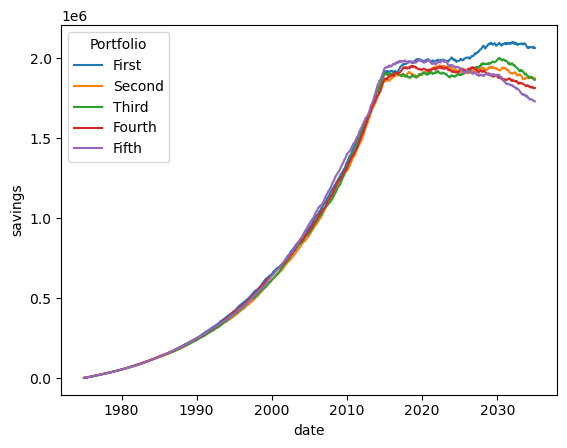

In [ ]:
# make an sns lineplot showing the savings over time for each portfolio
# only include entries whose months fall between month_start_savings and death_month
returns = returns[(returns['month'] >= month_start_savings) & (returns['month'] <= death_month)]

sns.lineplot(data=returns, x='date', y='savings', hue='Portfolio')